In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as Fn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [28]:
class VectorQuantizeImage(nn.Module):
    def __init__(self, codeBookDim = 64, embeddingDim = 32, decay = 0.99, eps = 1e-5):
        super().__init__()

        self.codeBookDim = codeBookDim
        self.embeddingDim = embeddingDim
        self.decay = decay
        self.eps = eps
        self.dead_codeBook_threshold = codeBookDim * 0.6

        self.codebook = nn.Embedding(codeBookDim, embeddingDim)
        nn.init.xavier_uniform_(self.codebook.weight.data)

        self.register_buffer('ema_Count', torch.zeros(codeBookDim))
        self.register_buffer('ema_Weight', self.codebook.weight.data.clone())

    def forward(self, x):
        x_reshaped = x.view(-1, self.embeddingDim)

        distance = (torch.sum(x_reshaped**2, dim=1, keepdim=True) 
                    + torch.sum(self.codebook.weight**2, dim=1)
                    - 2 * torch.matmul(x_reshaped, self.codebook.weight.t()))
        
        encoding_indices = torch.argmin(distance, dim=1) 
        encodings = Fn.one_hot(encoding_indices, self.codeBookDim).type(x_reshaped.dtype)
        quantized = torch.matmul(encodings, self.codebook.weight)

        if self.training:
            self.ema_Count = self.decay * self.ema_Count + (1 - self.decay) * torch.sum(encodings, 0)
            
            x_reshaped_sum = torch.matmul(encodings.t(), x_reshaped.detach())
            self.ema_Weight = self.decay * self.ema_Weight + (1 - self.decay) * x_reshaped_sum
            
            n = torch.clamp(self.ema_Count, min=self.eps)
            updated_embeddings = self.ema_Weight / n.unsqueeze(1)
            self.codebook.weight.data.copy_(updated_embeddings)

        
        avg_probs = torch.mean(encodings, dim=0)
        log_encoding_sum = -torch.sum(avg_probs * torch.log(avg_probs + 1e-10))
        perplexity = torch.exp(log_encoding_sum)

        entropy = log_encoding_sum
        normalized_entropy = entropy / torch.log(torch.tensor(self.codeBookDim, device=x.device))
        diversity_loss = 1.0 - normalized_entropy

        return quantized, encoding_indices, perplexity, diversity_loss
        
        
vq = VectorQuantizeImage(codeBookDim=64,embeddingDim=32)
rand = torch.randn(1024,32)
vq(rand)

(tensor([[ 0.0004, -0.0661, -0.1232,  ..., -0.1874,  0.1938,  0.1181],
         [ 0.0520, -0.0113,  0.1640,  ...,  0.1858,  0.2388,  0.2271],
         [ 0.1762,  0.1148, -0.0128,  ..., -0.1953, -0.1069,  0.2068],
         ...,
         [-0.2057, -0.0023, -0.2483,  ...,  0.1859, -0.1710,  0.0406],
         [-0.1338,  0.1255,  0.2342,  ...,  0.0977, -0.2008, -0.1665],
         [ 0.0981, -0.0529,  0.0776,  ..., -0.2376, -0.0575, -0.1241]],
        grad_fn=<MmBackward0>),
 tensor([38,  1, 48,  ..., 34, 14, 41]),
 tensor(60.8382),
 tensor(0.0122))

In [15]:
emb = nn.Embedding(num_embeddings = 10, embedding_dim=3)
emb

Embedding(10, 3)

In [17]:
emb[0]

TypeError: 'Embedding' object is not subscriptable

In [ ]:
num_tokens = 30
embed_dim = 10

embedding = nn.Embedding(num_tokens, embed_dim)

# Example token IDs
token_ids = torch.arange(num_tokens)

with torch.no_grad():
    vectors = embedding(token_ids)   # (10, 3)
emb = vectors.cpu().numpy()


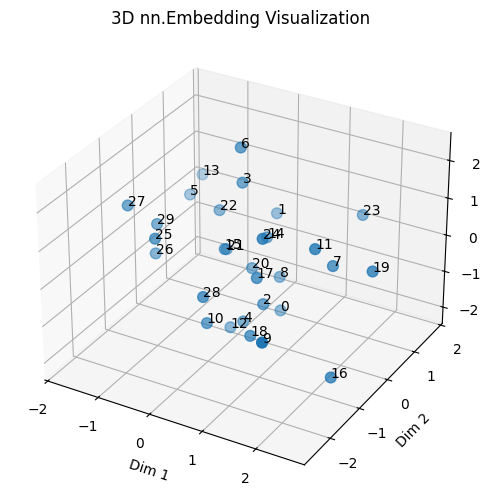

In [ ]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(emb[:, 0], emb[:, 1], emb[:, 2], s=60)

for i in range(len(emb)):
    ax.text(emb[i, 0], emb[i, 1], emb[i, 2], f"{i}", fontsize=10)

ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
ax.set_zlabel("Dim 3")
ax.set_title("3D nn.Embedding Visualization")

plt.show()
